# Automate Customer Support with Amazon Bedrock, LangGraph and Mistral models


## Use Case Overview


In this notebook, we use Agents to automate customer support tickets. Using AI agents to address customer support challenges is a transformative approach that leverages the power of AWS Cloud, Amazon Bedrock, LangChain, and LangGraph. This solution involves deploying intelligent agents capable of handling complex, multi-step tasks with contextual awareness and dynamic adaptability. For instance, a customer support bot can respnd to customer support issues like transaction failures, damaged product delivery, order enquiries, refund issues etc..

In this notebook, we are going to cover below support cases:

- Refund Issue
- Transaction Failure with transaction id in screenshot
- Delivery Failure - Recipient not available
- Damaged Product delivery - Compare customer shared picture with stock picture
- Customer Feedback
- Fraudulent Damaged product delivery claim where product images do not match
- Order enquiry - Order number found
- Order Enquiry - Order number not in database


## Tech Stack


In this innovative solution, customers initiate support requests via email, which are automatically converted into new support tickets in Atlassian Jira Service Management. The customer support automation system then takes over, identifying the intent behind each query, categorizing the tickets, and assigning them to a bot-user for further processing. The system extracts key identifiers such as transaction IDs and order numbers from the customer's query. It analyzes the query and uses these identifiers to call relevant tools, extracting additional information from internal systems to generate a comprehensive response. Once the response is prepared, it is updated in Jira for human support agents to review before sending it back to the customer. This system is capable of extracting information not only from the ticket body and title but also from attached images like screenshots and external systems.

The solution leverages multiple foundational models from Amazon Bedrock, each selected based on its specific capabilities and the complexity of the tasks involved. For instance, the Pixtral 12B model is utilized for vision-related tasks, while the Mistral Large model handles a variety of tasks. Additionally, the system includes robust fraud detection and prevention capabilities. It can identify fraudulent product returns by comparing the listed product with the returned product to verify if they match and assess whether the returned product is genuinely damaged. This integration of advanced AI models with automation tools enhances the efficiency and reliability of the customer support process, ensuring both timely resolutions and security against fraudulent activities.


![Tech stack](data/customer-support-tech-stack.png)


## Pre-requisites


In this notebook, we are using Atlassian Jira Service Management as an example. The same general approach can be used to integrate with other service management tools that provide APIs for programmatic access. The configuration required in Jira includes:

- A Jira service management project with API token to enable programmatic access
- Following custom fields:
  - Name: Category, Type: Select List (multiple choices)
  - Name: Response, Type: Text Field (multi-line)
- A bot user to assign tickets

In addition to Jira, the following services and Python packages are required:

- Access to Bedrock Models - Mistral Large 2 (24.07), Pixtral 12B
- Python packages like boto3, langchain, langgraph etc.
- SQLite database


Install python packages used in the notebook.


In [1]:
import sys
print(sys.version)

3.13.3 (main, Apr  8 2025, 13:54:08) [Clang 16.0.0 (clang-1600.0.26.6)]


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Install required packages
# %pip install -r requirements.txt

In [4]:
import os
import shutil

from cs_util import Utility
from cs_db import Database
from cs_langgraph import CustomerSupport, JiraAppState
from cs_bedrock import BedrockClient


## Implementation


### JIRA API Configuration


```
JIRA_API_TOKEN = "<JIRA_API_TOKEN>"
JIRA_USERNAME = "<JIRA_USERNAME>"
JIRA_INSTANCE_URL = "https://<YOUR_JIRA_INSTANCE_NAME>.atlassian.net/"
```


### Data Preparation


In [5]:
# import data from json files to sqlite database

db = Database()
db.import_all()

In [6]:
# test whether customers are imported
db.execute_query('select * from customers')

'[{"customer_id":1,"name":"John Smith","email":"johnsmith@gmail.com"},{"customer_id":2,"name":"Deepesh Dhapola","email":"dhapola@gmail.com"}]'

In [7]:
# create guardrails in Bedrock
bedrock_client = BedrockClient()
guardrail_id = bedrock_client.create_guardrail()

2025-04-24 17:24:51,321 - INFO - Found credentials in shared credentials file: ~/.aws/credentials


In [8]:
util = Utility()

### LangGraph Agents


## Run with Support Cases


In [9]:
thread = {"configurable": {"thread_id": "123456"}}


In [10]:
def generate_response_for_ticket(ticket_id: str):
    
    llm, vision_llm, llm_with_guardrails = bedrock_client.init_llms(ticket_id=ticket_id)
    cust_support = CustomerSupport(llm=llm, vision_llm=vision_llm, llm_with_guardrails=llm_with_guardrails)
    app   = cust_support.build_graph()
    
    state = cust_support.get_jira_ticket(key=ticket_id)
    state = app.invoke(state, thread)
    
    util.log_usage(state['usage'], ticket_id=ticket_id)
    util.log_execution_flow(state["messages"], ticket_id=ticket_id)

### Refund Issue


#### Jira Ticket - Initial


In [11]:
generate_response_for_ticket(ticket_id='AS-6')

2025-04-24 17:24:53,183 - INFO - Ticket: AS-6 -- Initializing Bedrock client
2025-04-24 17:24:53,183 - INFO - Ticket: AS-6 -- Using guardrail_id==> fdr0wu96vf6s
2025-04-24 17:24:53,208 - INFO - Ticket: NA -- Workflow compiled successfully
2025-04-24 17:24:53,209 - INFO -  #### get_jira_ticket ## Ticket: AS-6####


2025-04-24 17:24:54,099 - INFO -  #### determine_ticket_category_tool ## Ticket: AS-6####
2025-04-24 17:24:54,101 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:24:55,586 - INFO -  #### assign_ticket_category_in_jira_tool ## Ticket: AS-6####


2025-04-24 17:24:58,067 - INFO - Ticket: AS-6 -- Updated category to 'Refunds'
2025-04-24 17:24:58,068 - INFO -  #### decide_ticket_flow_condition ## Ticket: AS-6####
2025-04-24 17:24:58,070 - INFO -  #### extract_order_number_tool ## Ticket: AS-6####
2025-04-24 17:24:58,071 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:24:59,740 - INFO -  #### find_order_details_tool ## Ticket: AS-6####
2025-04-24 17:24:59,757 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:25:01,165 - INFO -  #### order_query_decision ## Ticket: AS-6####
2025-04-24 17:25:01,167 - INFO - Ticket: AS-6 -- [{'type': 'tool_use', 'name': 'find_refund_status', 'input': {'order_no': 'ORD00009996'}, 'id': 'tooluse_c_hHxahJTxKVNV7aBWmqiQ'}]
2025-04-24 17:25:01,172 - INFO -  #### find_refund_status ## Ticket: AS-6####
2025-04-24 17:25:01,177 - INFO - Ticket: AS-6 -- [{"customer_id":1,"refund_transaction_id":"KL345678901MN","transaction_id":"KL345678901MN","order_no":"ORD00009996","refund_transaction_date_time":"2025-03-03 14:20:45","status":"failed","failure_reason":"UPI ID not found","amount":24.99,"payment_method":"UPI","card_number_upi_id":"xxxx-xxxx-xxxx-3456"}]
2025-04-24 17:25:01,179 - INFO -  #### generate_response_tool ## Ticket: AS-6####
2025-04-24 17:25:01,180 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:25:01,717 - INFO -  #### update_response_in_jira_tool ## Ticket: AS-6####


2025-04-24 17:25:03,882 - INFO - Ticket: AS-6 -- Updated ticket with Response.
2025-04-24 17:25:03,887 - INFO - LLM Usage for Ticket: AS-6
Model                           Input Tokens    Output Tokens   Latency        
mistral.mistral-large-2407-v1:0  356            3              624            
mistral.mistral-large-2407-v1:0  424            27             834            
mistral.mistral-large-2407-v1:0  981            34             1126           
mistral.mistral-large-2407-v1:0  0              0              288            
2025-04-24 17:25:03,888 - INFO -  =========   Execution Flow for Ticket: AS-6  ========= 
2025-04-24 17:25:03,889 - INFO - ================================ System Message ================================

 
            You are a professional and courteous customer support agent for AnyCompany. Your goal is to assist users effectively and efficiently using the tools and information provided. 

            Guidelines:
            1. Maintain a polite, helpful, an

![Tech stack](data/AS-6-before.png)


#### Jira Ticket - Updated


![Tech stack](data/AS-6-updated.png)


### Transaction Failure Issue - with Screenshot


2025-04-24 17:25:03,916 - INFO - Ticket: AS-4 -- Initializing Bedrock client
2025-04-24 17:25:03,917 - INFO - Ticket: AS-4 -- Using guardrail_id==> fdr0wu96vf6s
2025-04-24 17:25:03,941 - INFO - Ticket: NA -- Workflow compiled successfully
2025-04-24 17:25:03,942 - INFO -  #### get_jira_ticket ## Ticket: AS-4####


2025-04-24 17:25:05,572 - INFO - Ticket: NA -- Downloaded: ./data/temp/AS-4-transaction_issue.png
2025-04-24 17:25:05,578 - INFO -  #### determine_ticket_category_tool ## Ticket: AS-4####
2025-04-24 17:25:05,579 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:25:06,916 - INFO -  #### assign_ticket_category_in_jira_tool ## Ticket: AS-4####


2025-04-24 17:25:08,174 - INFO - Ticket: AS-4 -- Updated category to 'Transaction'
2025-04-24 17:25:08,176 - INFO -  #### decide_ticket_flow_condition ## Ticket: AS-4####
2025-04-24 17:25:08,177 - INFO -  #### extract_transaction_id_tool ## Ticket: ####
2025-04-24 17:25:08,179 - INFO - Ticket: AS-4 -- image path ===> ./data/temp/AS-4-transaction_issue.png


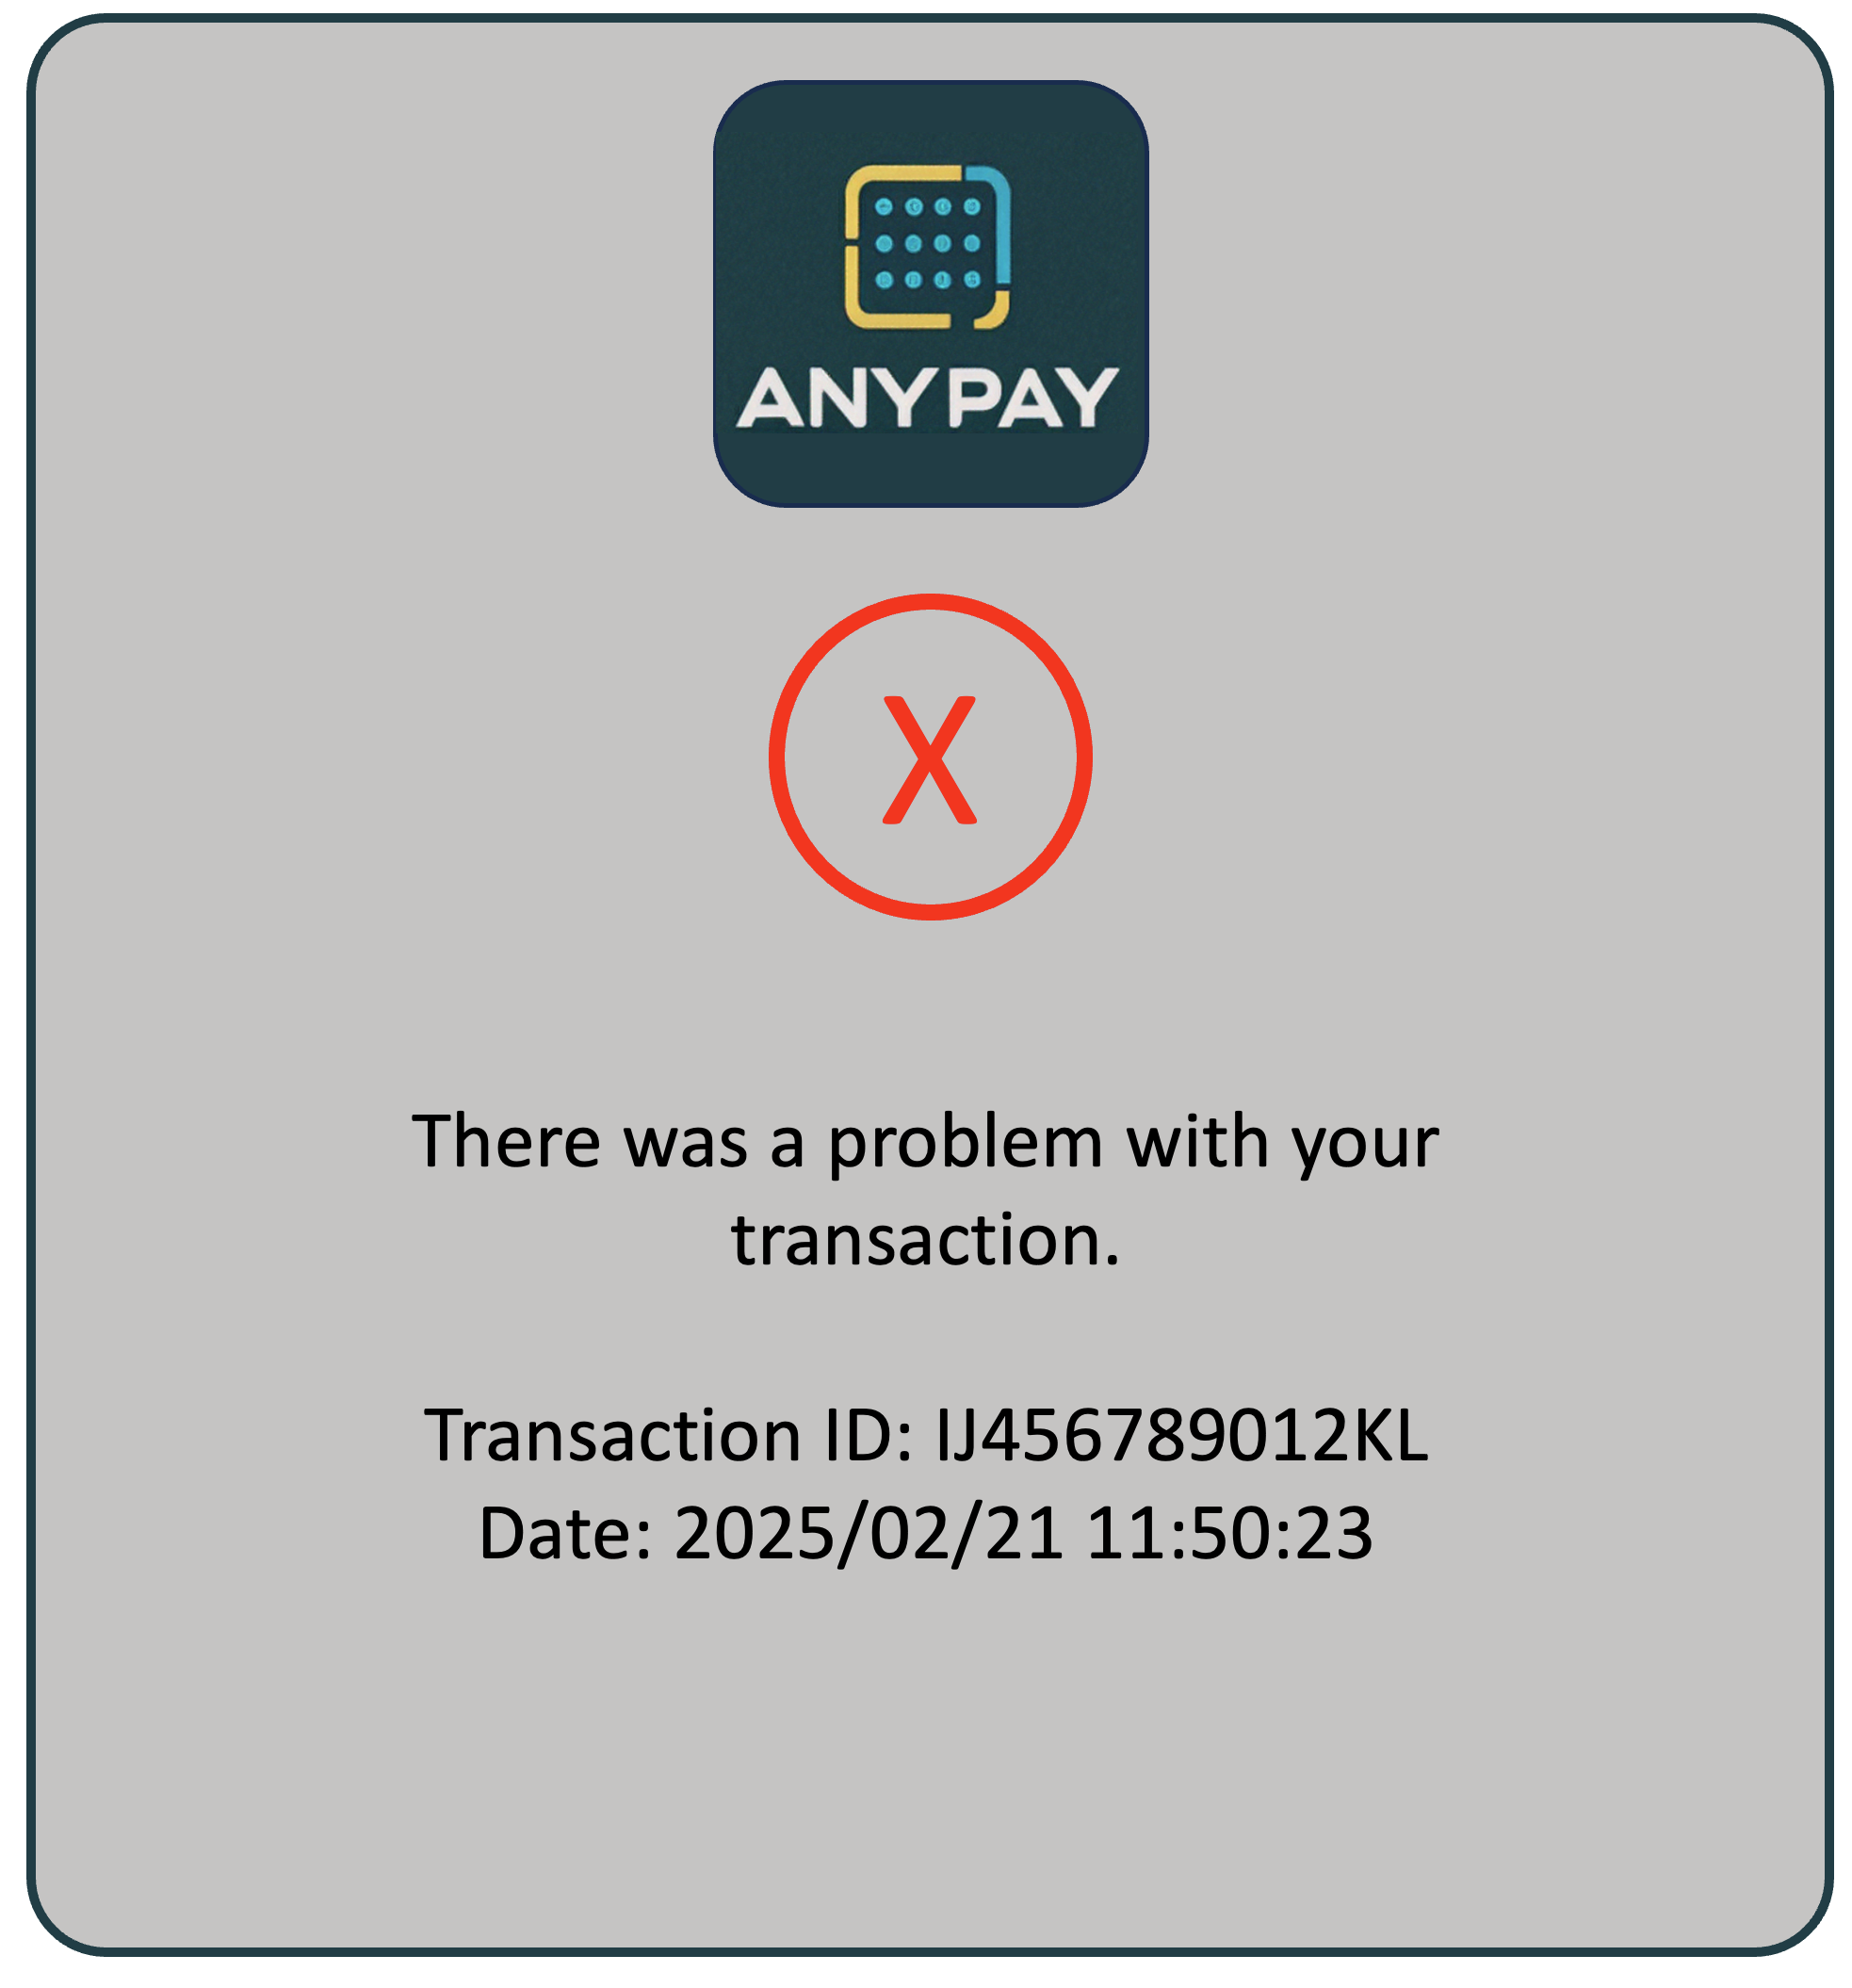

2025-04-24 17:25:08,200 - INFO - Using Bedrock Converse API to generate response
2025-04-24 17:25:11,711 - INFO -  #### find_transaction_details_tool ## Ticket: ####
2025-04-24 17:25:11,712 - INFO - Ticket: AS-4 -- IJ456789012KL
2025-04-24 17:25:11,717 - INFO - Ticket: AS-4 -- [{"transaction_id":"IJ456789012KL","order_no":"ORD00009990","transaction_date_time":"2025-02-21 11:50:23","status":"failure","failure_reason":"Declined by fraud detection","amount":89.99,"payment_method":"Debit Card","card_number_upi_id":"xxxx-xxxx-xxxx-7890"}] 
In case of transaction failures, customer's account is not debited
2025-04-24 17:25:11,718 - INFO -  #### generate_response_tool ## Ticket: AS-4####
2025-04-24 17:25:11,720 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:25:15,101 - INFO -  #### update_response_in_jira_tool ## Ticket: AS-4####


2025-04-24 17:25:16,474 - INFO - Ticket: AS-4 -- Updated ticket with Response.
2025-04-24 17:25:16,477 - INFO - LLM Usage for Ticket: AS-4
Model                              Input Tokens    Output Tokens   Latency        
mistral.mistral-large-2407-v1:0     314            1              562            
us.mistral.pixtral-large-2502-v1:0  3970           25             1406           
mistral.mistral-large-2407-v1:0     641            94             3118           
2025-04-24 17:25:16,477 - INFO -  =========   Execution Flow for Ticket: AS-4  ========= 
2025-04-24 17:25:16,478 - INFO - ================================ System Message ================================

 
            You are a professional and courteous customer support agent for AnyCompany. Your goal is to assist users effectively and efficiently using the tools and information provided. 

            Guidelines:
            1. Maintain a polite, helpful, and pleasant tone at all times.
            2. Avoid using strong or 

In [12]:
generate_response_for_ticket(ticket_id='AS-4')

#### Jira Ticket - Initial


![Tech stack](data/AS-4-before.png)


#### Jira Ticket - Updated


![Tech stack](data/AS-4-updated.png)


### Delivery Issue


In [13]:
generate_response_for_ticket(ticket_id='AS-7')

2025-04-24 17:25:16,492 - INFO - Ticket: AS-7 -- Initializing Bedrock client
2025-04-24 17:25:16,492 - INFO - Ticket: AS-7 -- Using guardrail_id==> fdr0wu96vf6s
2025-04-24 17:25:16,513 - INFO - Ticket: NA -- Workflow compiled successfully
2025-04-24 17:25:16,513 - INFO -  #### get_jira_ticket ## Ticket: AS-7####


2025-04-24 17:25:16,990 - INFO -  #### determine_ticket_category_tool ## Ticket: AS-7####
2025-04-24 17:25:16,991 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:25:18,351 - INFO -  #### assign_ticket_category_in_jira_tool ## Ticket: AS-7####


2025-04-24 17:25:19,692 - INFO - Ticket: AS-7 -- Updated category to 'Delivery'
2025-04-24 17:25:19,694 - INFO -  #### decide_ticket_flow_condition ## Ticket: AS-7####
2025-04-24 17:25:19,696 - INFO -  #### extract_order_number_tool ## Ticket: AS-7####
2025-04-24 17:25:19,699 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:25:21,294 - INFO -  #### find_order_details_tool ## Ticket: AS-7####
2025-04-24 17:25:21,310 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:25:22,597 - INFO -  #### order_query_decision ## Ticket: AS-7####
2025-04-24 17:25:22,599 - INFO - Ticket: AS-7 -- [{"name": "find_refund_status", "arguments": {"order_no": "ORD00009987"}}]
2025-04-24 17:25:22,601 - INFO -  #### generate_response_tool ## Ticket: AS-7####
2025-04-24 17:25:22,603 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:25:28,025 - INFO -  #### update_response_in_jira_tool ## Ticket: AS-7####


2025-04-24 17:25:29,593 - INFO - Ticket: AS-7 -- Updated ticket with Response.
2025-04-24 17:25:29,596 - INFO - LLM Usage for Ticket: AS-7
Model                           Input Tokens    Output Tokens   Latency        
mistral.mistral-large-2407-v1:0  349            2              578            
mistral.mistral-large-2407-v1:0  416            26             805            
mistral.mistral-large-2407-v1:0  973            33             1042           
mistral.mistral-large-2407-v1:0  922            158            5137           
2025-04-24 17:25:29,597 - INFO -  =========   Execution Flow for Ticket: AS-7  ========= 
2025-04-24 17:25:29,598 - INFO - ================================ System Message ================================

 
            You are a professional and courteous customer support agent for AnyCompany. Your goal is to assist users effectively and efficiently using the tools and information provided. 

            Guidelines:
            1. Maintain a polite, helpful, an

#### Jira Ticket - Initial


![Tech stack](data/AS-7-before.png)


#### Jira Ticket - Updated


![Tech stack](data/AS-7-updated.png)


### Damaged Product Delivery - Visual damage assessment


2025-04-24 17:25:29,619 - INFO - Ticket: AS-5 -- Initializing Bedrock client
2025-04-24 17:25:29,619 - INFO - Ticket: AS-5 -- Using guardrail_id==> fdr0wu96vf6s
2025-04-24 17:25:29,647 - INFO - Ticket: NA -- Workflow compiled successfully
2025-04-24 17:25:29,648 - INFO -  #### get_jira_ticket ## Ticket: AS-5####


2025-04-24 17:25:31,025 - INFO - Ticket: NA -- Downloaded: ./data/temp/AS-5-delivered-bottle.jpg
2025-04-24 17:25:31,031 - INFO -  #### determine_ticket_category_tool ## Ticket: AS-5####
2025-04-24 17:25:31,033 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:25:32,406 - INFO -  #### assign_ticket_category_in_jira_tool ## Ticket: AS-5####


2025-04-24 17:25:33,860 - INFO - Ticket: AS-5 -- Updated category to 'Delivery'
2025-04-24 17:25:33,863 - INFO -  #### decide_ticket_flow_condition ## Ticket: AS-5####
2025-04-24 17:25:33,865 - INFO -  #### extract_order_number_tool ## Ticket: AS-5####
2025-04-24 17:25:33,867 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:25:35,502 - INFO -  #### find_order_details_tool ## Ticket: AS-5####
2025-04-24 17:25:35,519 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:25:36,903 - INFO -  #### order_query_decision ## Ticket: AS-5####
2025-04-24 17:25:36,904 - INFO - Ticket: AS-5 -- [{'type': 'tool_use', 'name': 'assess_damaged_delivery', 'input': {'order_no': 'ORD00009997'}, 'id': 'tooluse_Rk9vbiGIR6OxWbVr2xvhnQ'}]
2025-04-24 17:25:36,909 - INFO -  #### assess_damaged_delivery ## Ticket: AS-5####
2025-04-24 17:25:36,910 - INFO - Ticket: AS-5 -- image path ===> ./data/listed-bottle.jpg
2025-04-24 17:25:36,913 - INFO - Ticket: AS-5 -- image path ===> ./data/temp/AS-5-delivered-bottle.jpg
2025-04-24 17:25:36,914 - INFO - Ticket: AS-5 -- Listed Product Picture


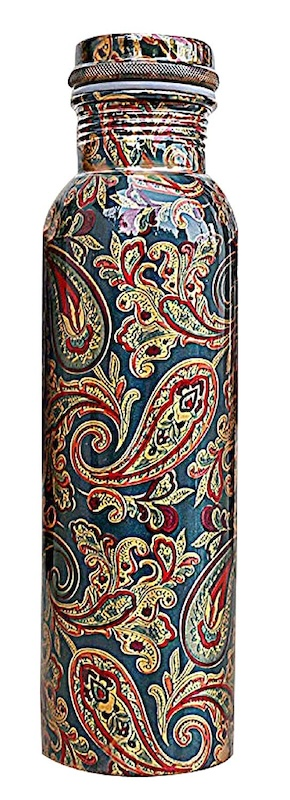

2025-04-24 17:25:36,919 - INFO - Ticket: AS-5 -- Customer Shared Picture


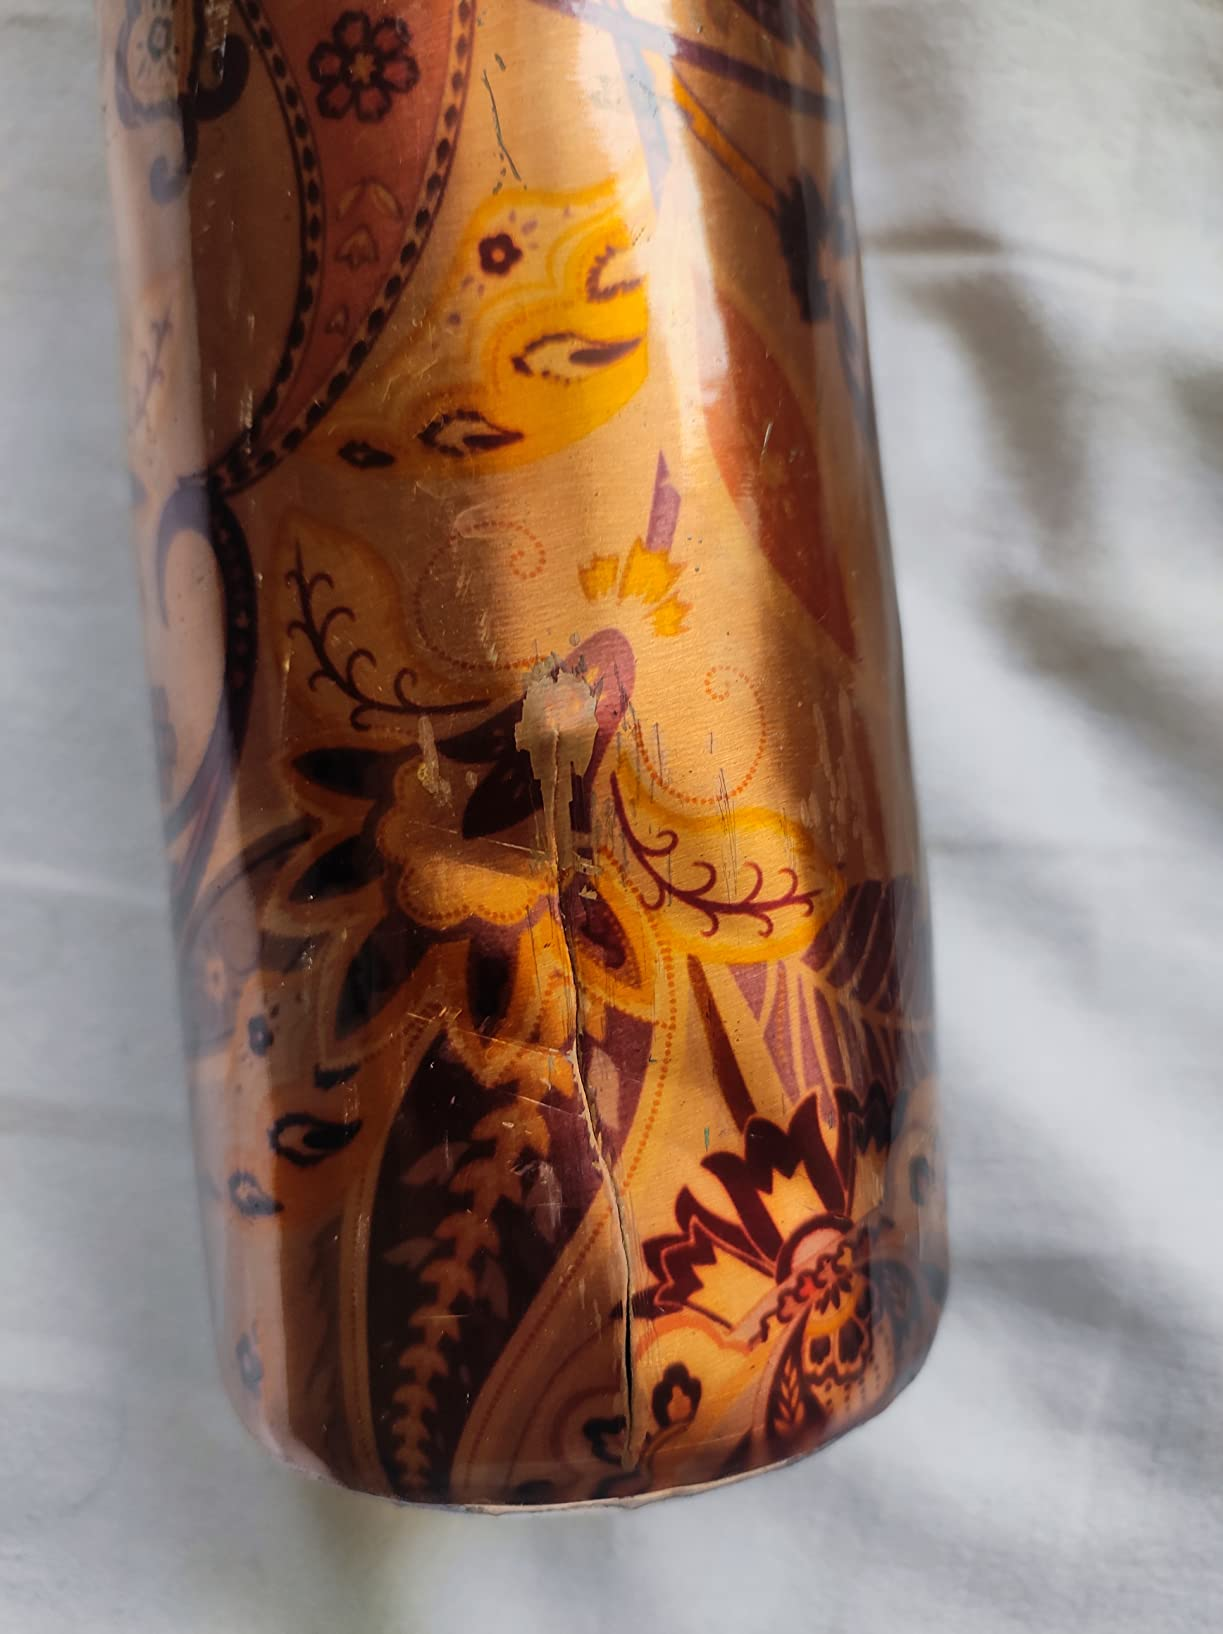

2025-04-24 17:25:36,930 - INFO - Using Bedrock Converse API to generate response
2025-04-24 17:25:46,039 - INFO -  #### generate_response_tool ## Ticket: AS-5####
2025-04-24 17:25:46,041 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:25:50,959 - INFO -  #### update_response_in_jira_tool ## Ticket: AS-5####


2025-04-24 17:25:52,144 - INFO - Ticket: AS-5 -- Updated ticket with Response.
2025-04-24 17:25:52,148 - INFO - LLM Usage for Ticket: AS-5
Model                              Input Tokens    Output Tokens   Latency        
mistral.mistral-large-2407-v1:0     385            2              560            
mistral.mistral-large-2407-v1:0     452            27             832            
mistral.mistral-large-2407-v1:0     1039           36             1126           
us.mistral.pixtral-large-2502-v1:0  4632           535            7265           
mistral.mistral-large-2407-v1:0     1990           153            4638           
2025-04-24 17:25:52,149 - INFO -  =========   Execution Flow for Ticket: AS-5  ========= 
2025-04-24 17:25:52,150 - INFO - ================================ System Message ================================

 
            You are a professional and courteous customer support agent for AnyCompany. Your goal is to assist users effectively and efficiently using the tools 

In [14]:
generate_response_for_ticket(ticket_id='AS-5')

#### Jira Ticket - Initial


![Tech stack](data/AS-5-before.png)


#### Jira Ticket - Updated


![Tech stack](data/AS-5-updated.png)


### Appreciation note from Customer


In [15]:

generate_response_for_ticket(ticket_id='AS-8')

2025-04-24 17:25:52,184 - INFO - Ticket: AS-8 -- Initializing Bedrock client
2025-04-24 17:25:52,185 - INFO - Ticket: AS-8 -- Using guardrail_id==> fdr0wu96vf6s
2025-04-24 17:25:52,206 - INFO - Ticket: NA -- Workflow compiled successfully
2025-04-24 17:25:52,206 - INFO -  #### get_jira_ticket ## Ticket: AS-8####


2025-04-24 17:25:52,866 - INFO -  #### determine_ticket_category_tool ## Ticket: AS-8####
2025-04-24 17:25:52,868 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:25:54,154 - INFO -  #### assign_ticket_category_in_jira_tool ## Ticket: AS-8####


2025-04-24 17:25:55,317 - INFO - Ticket: AS-8 -- Updated category to 'Other'
2025-04-24 17:25:55,319 - INFO -  #### decide_ticket_flow_condition ## Ticket: AS-8####
2025-04-24 17:25:55,320 - INFO -  #### extract_order_number_tool ## Ticket: AS-8####
2025-04-24 17:25:55,322 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:25:56,871 - INFO -  #### find_order_details_tool ## Ticket: AS-8####
2025-04-24 17:25:56,880 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:25:58,342 - INFO -  #### order_query_decision ## Ticket: AS-8####
2025-04-24 17:25:58,344 - INFO - Ticket: AS-8 -- I'm glad to hear that you had a pleasant experience with our service desk. If you have any other issues or need further assistance, please feel free to reach out. Have a nice day!
2025-04-24 17:25:58,346 - INFO -  #### generate_response_tool ## Ticket: AS-8####
2025-04-24 17:25:58,348 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:26:08,525 - INFO -  #### update_response_in_jira_tool ## Ticket: AS-8####


2025-04-24 17:26:09,921 - INFO - Ticket: AS-8 -- Updated ticket with Response.
2025-04-24 17:26:09,924 - INFO - LLM Usage for Ticket: AS-8
Model                           Input Tokens    Output Tokens   Latency        
mistral.mistral-large-2407-v1:0  351            1              535            
mistral.mistral-large-2407-v1:0  417            20             710            
mistral.mistral-large-2407-v1:0  846            40             1203           
mistral.mistral-large-2407-v1:0  809            80             2625           
2025-04-24 17:26:09,925 - INFO -  =========   Execution Flow for Ticket: AS-8  ========= 
2025-04-24 17:26:09,925 - INFO - ================================ System Message ================================

 
            You are a professional and courteous customer support agent for AnyCompany. Your goal is to assist users effectively and efficiently using the tools and information provided. 

            Guidelines:
            1. Maintain a polite, helpful, an

#### Jira Ticket - Initial


![Tech stack](data/AS-8-before.png)


#### Jira Ticket - Updated


![Tech stack](data/AS-8-updated.png)


### Fraudulent Damaged Claim - Visual image assessment


2025-04-24 17:47:26,393 - INFO - Ticket: AS-11 -- Initializing Bedrock client
2025-04-24 17:47:26,394 - INFO - Ticket: AS-11 -- Using guardrail_id==> fdr0wu96vf6s
2025-04-24 17:47:26,416 - INFO - Ticket: NA -- Workflow compiled successfully
2025-04-24 17:47:26,417 - INFO -  #### get_jira_ticket ## Ticket: AS-11####


2025-04-24 17:47:27,896 - INFO - Ticket: NA -- Downloaded: ./data/temp/AS-11-broken_bottle.jpg
2025-04-24 17:47:27,904 - INFO -  #### determine_ticket_category_tool ## Ticket: AS-11####
2025-04-24 17:47:27,906 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:47:29,393 - INFO -  #### assign_ticket_category_in_jira_tool ## Ticket: AS-11####


2025-04-24 17:47:30,532 - INFO - Ticket: AS-11 -- Updated category to 'Delivery'
2025-04-24 17:47:30,534 - INFO -  #### decide_ticket_flow_condition ## Ticket: AS-11####
2025-04-24 17:47:30,536 - INFO -  #### extract_order_number_tool ## Ticket: AS-11####
2025-04-24 17:47:30,538 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:47:32,214 - INFO -  #### find_order_details_tool ## Ticket: AS-11####
2025-04-24 17:47:32,232 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:47:33,635 - INFO -  #### order_query_decision ## Ticket: AS-11####
2025-04-24 17:47:33,637 - INFO - Ticket: AS-11 -- [{'type': 'tool_use', 'name': 'assess_damaged_delivery', 'input': {'order_no': 'ORD00009997'}, 'id': 'tooluse_CkXKLLFdTQWh7ZIrdYqa0g'}]
2025-04-24 17:47:33,640 - INFO -  #### assess_damaged_delivery ## Ticket: AS-11####
2025-04-24 17:47:33,641 - INFO - Ticket: AS-11 -- image path ===> ./data/listed-bottle.jpg
2025-04-24 17:47:33,643 - INFO - Ticket: AS-11 -- image path ===> ./data/temp/AS-11-broken_bottle.jpg
2025-04-24 17:47:33,645 - INFO - Ticket: AS-11 -- Listed Product Picture


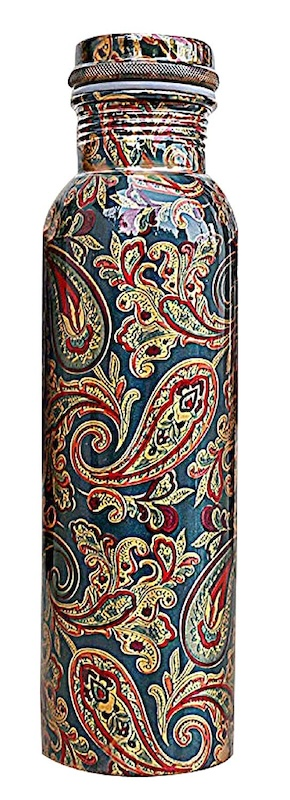

2025-04-24 17:47:33,648 - INFO - Ticket: AS-11 -- Customer Shared Picture


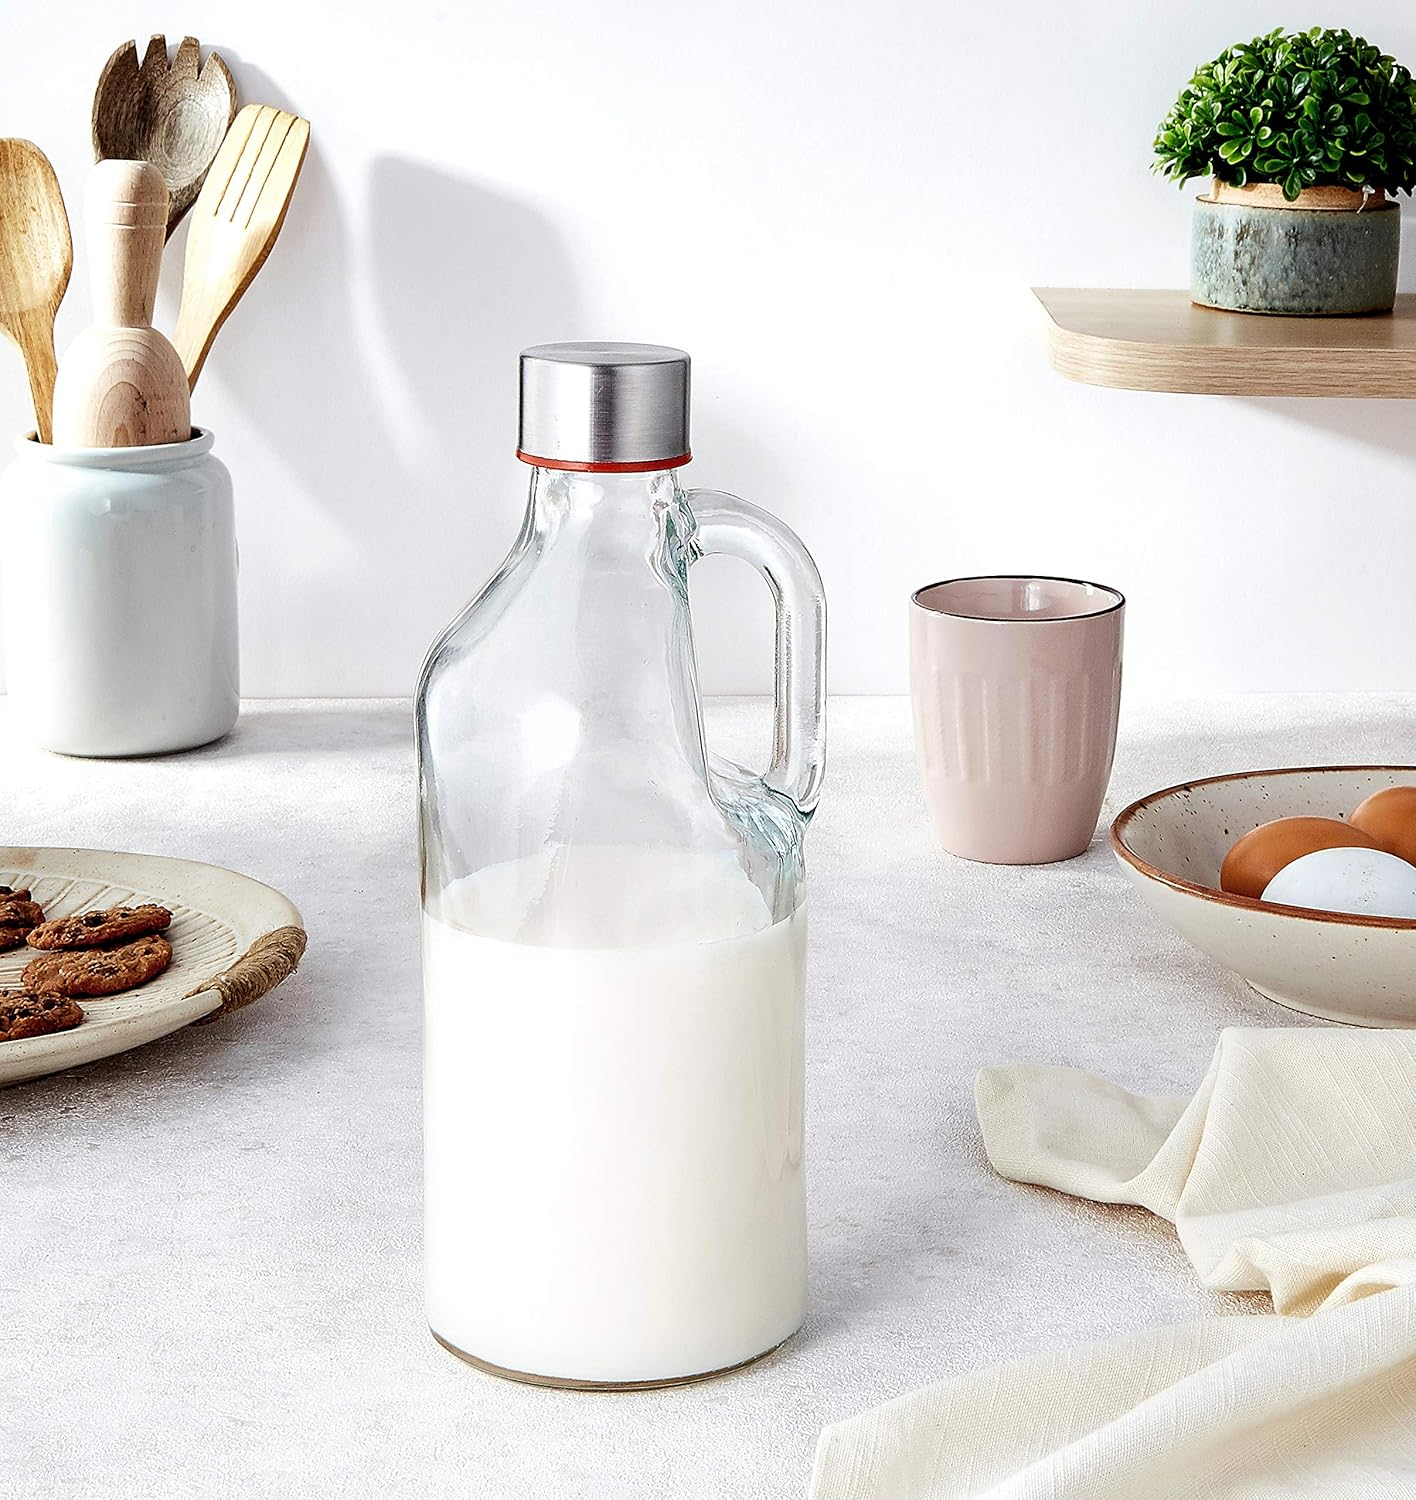

2025-04-24 17:47:33,658 - INFO - Using Bedrock Converse API to generate response
2025-04-24 17:47:42,382 - INFO -  #### generate_response_tool ## Ticket: AS-11####
2025-04-24 17:47:42,385 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:47:46,767 - INFO -  #### update_response_in_jira_tool ## Ticket: AS-11####


2025-04-24 17:47:48,064 - INFO - Ticket: AS-11 -- Updated ticket with Response.
2025-04-24 17:47:48,068 - INFO - LLM Usage for Ticket: AS-11
Model                              Input Tokens    Output Tokens   Latency        
mistral.mistral-large-2407-v1:0     336            2              690            
mistral.mistral-large-2407-v1:0     403            26             894            
mistral.mistral-large-2407-v1:0     940            36             1147           
us.mistral.pixtral-large-2502-v1:0  5464           415            6302           
mistral.mistral-large-2407-v1:0     1651           131            4126           
2025-04-24 17:47:48,069 - INFO -  =========   Execution Flow for Ticket: AS-11  ========= 
2025-04-24 17:47:48,069 - INFO - ================================ System Message ================================

 
            You are a professional and courteous customer support agent for AnyCompany. Your goal is to assist users effectively and efficiently using the too

In [21]:

generate_response_for_ticket(ticket_id='AS-11')

#### Jira Ticket - Initial


![Tech stack](data/AS-11-before.png)


#### Jira Ticket - Updated


![Tech stack](data/AS-11-updated.png)


### Order Status Enquiry


In [18]:
generate_response_for_ticket(ticket_id='AS-9')

2025-04-24 17:44:27,407 - INFO - Ticket: AS-9 -- Initializing Bedrock client
2025-04-24 17:44:27,409 - INFO - Ticket: AS-9 -- Using guardrail_id==> fdr0wu96vf6s
2025-04-24 17:44:27,438 - INFO - Ticket: NA -- Workflow compiled successfully
2025-04-24 17:44:27,438 - INFO -  #### get_jira_ticket ## Ticket: AS-9####


2025-04-24 17:44:28,420 - INFO -  #### determine_ticket_category_tool ## Ticket: AS-9####
2025-04-24 17:44:28,422 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:44:29,968 - INFO -  #### assign_ticket_category_in_jira_tool ## Ticket: AS-9####


2025-04-24 17:44:31,318 - INFO - Ticket: AS-9 -- Updated category to 'Delivery'
2025-04-24 17:44:31,319 - INFO -  #### decide_ticket_flow_condition ## Ticket: AS-9####
2025-04-24 17:44:31,321 - INFO -  #### extract_order_number_tool ## Ticket: AS-9####
2025-04-24 17:44:31,327 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:44:33,011 - INFO -  #### find_order_details_tool ## Ticket: AS-9####
2025-04-24 17:44:33,033 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:44:35,764 - INFO -  #### order_query_decision ## Ticket: AS-9####
2025-04-24 17:44:35,764 - INFO - Ticket: AS-9 -- Hi Deepesh,

Thank you for reaching out. Your order with order number ORD00009991 is currently in processing. The estimated time of delivery is February 18, 2025, at 10:45 AM.

Please let us know if you have any further questions.

Best regards,

[Your Name]

Customer Support

AnyCompany
2025-04-24 17:44:35,767 - INFO -  #### generate_response_tool ## Ticket: AS-9####
2025-04-24 17:44:35,768 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:44:39,043 - INFO -  #### update_response_in_jira_tool ## Ticket: AS-9####


2025-04-24 17:44:40,386 - INFO - Ticket: AS-9 -- Updated ticket with Response.
2025-04-24 17:44:40,390 - INFO - LLM Usage for Ticket: AS-9
Model                           Input Tokens    Output Tokens   Latency        
mistral.mistral-large-2407-v1:0  353            2              667            
mistral.mistral-large-2407-v1:0  420            27             831            
mistral.mistral-large-2407-v1:0  955            90             2479           
mistral.mistral-large-2407-v1:0  1018           90             3001           
2025-04-24 17:44:40,391 - INFO -  =========   Execution Flow for Ticket: AS-9  ========= 
2025-04-24 17:44:40,392 - INFO - ================================ System Message ================================

 
            You are a professional and courteous customer support agent for AnyCompany. Your goal is to assist users effectively and efficiently using the tools and information provided. 

            Guidelines:
            1. Maintain a polite, helpful, an

#### Jira Ticket - Initial


![Tech stack](data/AS-9-before.png)


#### Jira Ticket - Updated


![Tech stack](data/AS-9-updated.png)


### Order Status Enquiry (incorrect order number)


In [20]:
generate_response_for_ticket(ticket_id='AS-10')

2025-04-24 17:46:22,661 - INFO - Ticket: AS-10 -- Initializing Bedrock client
2025-04-24 17:46:22,662 - INFO - Ticket: AS-10 -- Using guardrail_id==> fdr0wu96vf6s
2025-04-24 17:46:22,691 - INFO - Ticket: NA -- Workflow compiled successfully
2025-04-24 17:46:22,692 - INFO -  #### get_jira_ticket ## Ticket: AS-10####


2025-04-24 17:46:23,543 - INFO -  #### determine_ticket_category_tool ## Ticket: AS-10####
2025-04-24 17:46:23,545 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:46:25,237 - INFO -  #### assign_ticket_category_in_jira_tool ## Ticket: AS-10####


2025-04-24 17:46:26,575 - INFO - Ticket: AS-10 -- Updated category to 'Delivery'
2025-04-24 17:46:26,577 - INFO -  #### decide_ticket_flow_condition ## Ticket: AS-10####
2025-04-24 17:46:26,579 - INFO -  #### extract_order_number_tool ## Ticket: AS-10####
2025-04-24 17:46:26,582 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:46:28,270 - INFO -  #### find_order_details_tool ## Ticket: AS-10####
2025-04-24 17:46:28,281 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:46:30,899 - INFO -  #### order_query_decision ## Ticket: AS-10####
2025-04-24 17:46:30,900 - INFO - Ticket: AS-10 -- Dear Deepesh,

Thank you for reaching out to us.

I checked the details of your order ORD456345jkl345, but unfortunately, I did not find any records. Could you please provide additional details or confirm the order number so that I can assist you better?

Best regards,
[Your Name]
AnyCompany Support
2025-04-24 17:46:30,903 - INFO -  #### generate_response_tool ## Ticket: AS-10####
2025-04-24 17:46:30,905 - INFO - Using Bedrock Converse API to generate response


2025-04-24 17:46:34,084 - INFO -  #### update_response_in_jira_tool ## Ticket: AS-10####


2025-04-24 17:46:35,338 - INFO - Ticket: AS-10 -- Updated ticket with Response.
2025-04-24 17:46:35,342 - INFO - LLM Usage for Ticket: AS-10
Model                           Input Tokens    Output Tokens   Latency        
mistral.mistral-large-2407-v1:0  348            2              718            
mistral.mistral-large-2407-v1:0  415            29             932            
mistral.mistral-large-2407-v1:0  866            80             2370           
mistral.mistral-large-2407-v1:0  909            84             2887           
2025-04-24 17:46:35,342 - INFO -  =========   Execution Flow for Ticket: AS-10  ========= 
2025-04-24 17:46:35,343 - INFO - ================================ System Message ================================

 
            You are a professional and courteous customer support agent for AnyCompany. Your goal is to assist users effectively and efficiently using the tools and information provided. 

            Guidelines:
            1. Maintain a polite, helpful,

#### Jira Ticket - Initial


![Tech stack](data/AS-10-before.png)


#### Jira Ticket - Updated


![Tech stack](data/AS-10-updated.png)


## Cleanup


This notebook created a temp directory under ./data directory. Below cell deletes the contents of ./data/temp directory.


In [ ]:
# delete temporary files created 
# shutil.rmtree(util.get_temp_path())
# bedrock_client.delete_guardrail()